# Module 11 – Decision Trees: Hands-on Notebook

This Colab-friendly notebook covers:
- **11.3 – Building a simple decision tree with synthetic data**
- **11.4 – Overfitting and pruning**
- **11.5 – Evaluating a decision tree (accuracy, precision, recall, F1, confusion matrix)**
- **11.6 – ROC curve and AUC**

Each part starts with an explanation in text, then shows simple code and plots.

## Common Imports

In this cell we import the libraries we will use across all parts:
- `pandas` for data handling
- `numpy` for numeric operations
- `matplotlib` for plots
- `sklearn` for machine learning models and metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)

# Make plots a bit larger by default
plt.rcParams['figure.figsize'] = (7, 5)

---
# Module 11.3 – Building a Simple Decision Tree (Synthetic Data)

In this section, we will:
- Create a tiny synthetic dataset with two features
- Train a decision tree classifier
- Visualize the learned tree
- Interpret what the tree is doing

This is only for **intuition**. We keep it very small so students can follow every step.

### 11.3.1 Create a small synthetic dataset

We use a toy example similar to the slides:
- `Weather`: Sunny or Rainy
- `Windy`: 0 (No) or 1 (Yes)
- `Play`: 1 (Play) or 0 (Do not play)

We first create this dataset as a pandas DataFrame.

In [2]:
#Create a small synthetic dataset
data = {
    'Weather': ['Sunny', 'Rainy', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny', 'Rainy'],
    'Windy':   [0,        1,       0,        1,        0,        1,        0,       1],
    'Play':    [1,        0,       1,        1,        0,        0,        1,       0]
}
df_synthetic = pd.DataFrame(data)
df_synthetic

,Weather,Windy,Play
0,Sunny,0,1
1,Rainy,1,0
2,Sunny,0,1
3,Sunny,1,1
4,Rainy,0,0
5,Rainy,1,0
6,Sunny,0,1
7,Rainy,1,0


### 11.3.2 Encode categorical feature and prepare X, y

Machine learning models in `sklearn` expect numeric inputs.
We will encode:
- `Sunny` → 1
- `Rainy` → 0

`Windy` is already numeric (0/1), so we can use it directly.
The target variable `Play` is already 0/1.

In [18]:
#Encode categorical feature and prepare X, y
df_synthetic['Weather_num'] = df_synthetic['Weather'].map({'Sunny': 1, 'Rainy': 0})
X_synthetic = df_synthetic[['Weather_num', 'Windy']]
y_synthetic = df_synthetic['Play']
print(X_synthetic)
print(y_synthetic)


   Weather_num  Windy
0            1      0
1            0      1
2            1      0
3            1      1
4            0      0
5            0      1
6            1      0
7            0      1
0    1
1    0
2    1
3    1
4    0
5    0
6    1
7    0
Name: Play, dtype: int64


### 11.3.3 Train a simple decision tree

We now train a decision tree classifier.

- We set `max_depth=3` just to keep the tree small.
- We fit the model on **all** data (since the goal here is intuition, not evaluation).

In [19]:
#Train a simple decision tree
tree_syn=DecisionTreeClassifier(max_depth=3,random_state=42)
tree_syn.fit(X_synthetic, y_synthetic)
tree_syn

DecisionTreeClassifier(max_depth=3, random_state=42)

### 11.3.4 Visualize the tree

Now we plot the tree. This helps students see:
- The root split
- Branches
- Leaf predictions
- How many samples go to each node

Note: `class_names=['No', 'Yes']` aligns with `Play`: 0 = No, 1 = Yes.

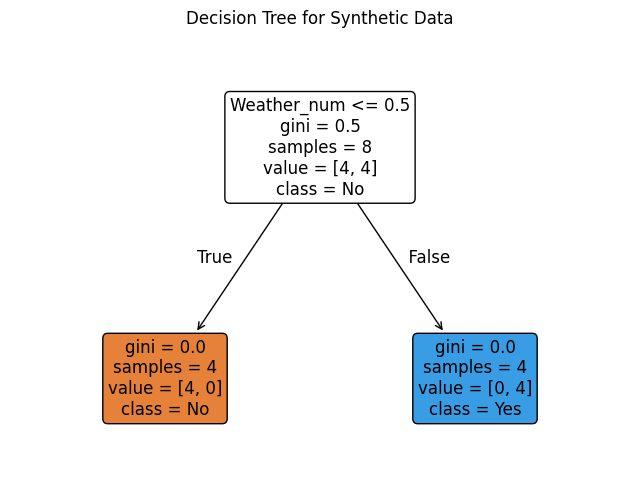

In [22]:
#Visualize the tree
plt.figure(figsize=(8, 6))
plot_tree(
    tree_syn,
    feature_names=['Weather_num', 'Windy'],
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,

    fontsize=12
)
plt.title('Decision Tree for Synthetic Data')
plt.show()


### 11.3.5 Quick prediction examples

We can now test how the model behaves on a few example cases.
You can ask students to **guess the output** before showing the prediction.

In [25]:
# Example: Sunny (1), not windy (0)

example_1=pd.DataFrame([[1,0]],columns=['Weather_num','Windy'])
pred_1=tree_syn.predict(example_1)
print(f"Prediction for example 1: {pred_1[0]}")
# Example: Rainy (0), windy (1)
example_2=pd.DataFrame([[0,1]],columns=['Weather_num','Windy'])
pred_2=tree_syn.predict(example_2)
print(f"Prediction for example 2: {pred_2[0]}")


Prediction for example 1: 1
Prediction for example 2: 0


---
# Module 11.4 – Overfitting and Pruning

In this section, we will:
- See how a **deep tree** can overfit
- Compare it with a **pruned tree** using `max_depth`
- Compare training vs test performance

We will use a slightly larger synthetic dataset so that overfitting becomes visible.

### 11.4.1 Create a slightly larger synthetic dataset

We create a synthetic binary classification dataset using `sklearn.datasets.make_classification`.
This is not a real medical dataset, but it is enough to show overfitting clearly.

In [35]:
#Create a slightly larger synthetic dataset
from sklearn.datasets import make_classification
x_Big,Y_Big=make_classification(
    n_samples=400, #Total Data Points
    n_features=5, #Total Features number
    n_informative=3, #Total Relevant featureas number
    n_redundant=0, #No strong co relation among the features
    n_classes=2, # Target variable/ feture class no
    random_state=42 # Every time we will get the simillar random dataset
)
x_train_big,x_test_big,y_train_big,y_test_big=train_test_split(
    x_Big,Y_Big,test_size=0.3,random_state=42
    )
x_train_big.shape,x_test_big.shape,y_train_big.shape,y_test_big.shape


((280, 5), (120, 5), (280,), (120,))

### 11.4.2 Train a deep tree vs a pruned tree

We now train two models:
- `deep_tree`: no depth limit (can easily overfit)
- `pruned_tree`: `max_depth=3`

We compare their **training** and **test** accuracy.

In [36]:
#Train a deep tree vs a pruned tree
deep_tree=DecisionTreeClassifier(random_state=42)
deep_tree.fit(x_train_big,y_train_big)

pruned_tree=DecisionTreeClassifier(max_depth=3,random_state=42)
pruned_tree.fit(x_train_big,y_train_big)

y_train_pred_deep=deep_tree.predict(x_train_big)
y_test_pred_deep=deep_tree.predict(x_test_big)


y_train_pred_pruned=pruned_tree.predict(x_train_big)
y_test_pred_pruned=pruned_tree.predict(x_test_big)

print('Deep tree – train accuracy:', round(accuracy_score(y_train_big, y_train_pred_deep), 3))
print('Deep tree – test accuracy :', round(accuracy_score(y_test_big, y_test_pred_deep), 3))
print()
print('Pruned tree – train accuracy:', round(accuracy_score(y_train_big, y_train_pred_pruned), 3))
print('Pruned tree – test accuracy :', round(accuracy_score(y_test_big, y_test_pred_pruned), 3))


Deep tree – train accuracy: 1.0
Deep tree – test accuracy : 0.883

Pruned tree – train accuracy: 0.904
Pruned tree – test accuracy : 0.892


### 11.4.3 Visual comparison of deep vs pruned trees

We now visualize both trees. The deep tree will usually be more complex than the pruned one.

To keep the plots readable, we only show a few top levels of the deep tree.

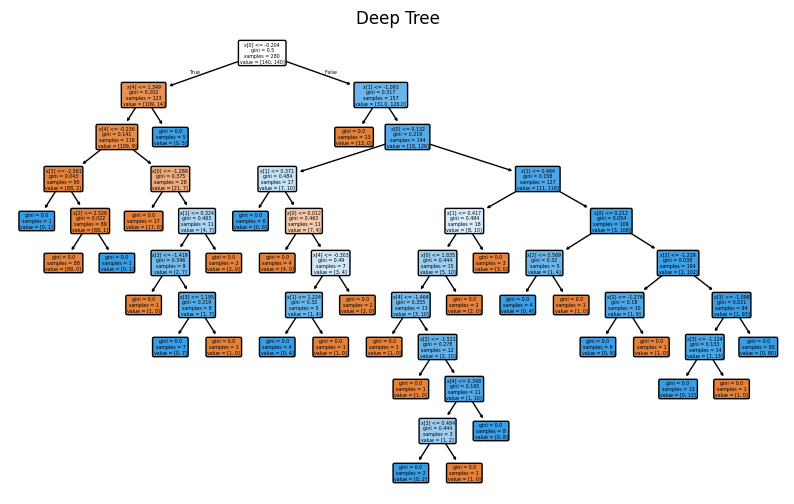

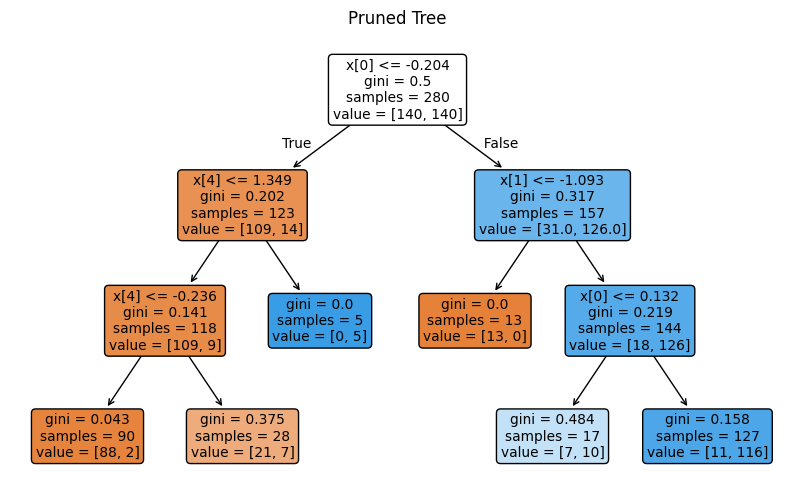

In [40]:
# Plot deep tree (showing only top levels for readability)
plt.figure(figsize=(10, 6))
plot_tree(
    deep_tree,
    filled=True,
    rounded=True
    )
plt.title('Deep Tree')
plt.show()
# Plot a Prunned Tree
plt.figure(figsize=(10,6))
plot_tree(
    pruned_tree,
    filled=True,
    rounded=True
)
plt.title('Pruned Tree')
plt.show()



From the accuracy and the plots you can highlight:
- Deep tree often has **very high training accuracy** but may drop on test data.
- Pruned tree has slightly lower training accuracy but often **better or more stable test performance**.

This demonstrates **overfitting vs generalization**.

---
# Module 11.5 – Evaluating a Decision Tree (Accuracy, Precision, Recall, F1, Confusion Matrix)

In this section, we will:
- Create a **heart-disease-like** synthetic dataset
- Train a decision tree classifier
- Compute and interpret:
  - Confusion matrix
  - Accuracy
  - Precision
  - Recall
  - F1 score


### 11.5.1 Create a toy heart-disease-like dataset

We simulate a dataset with a few features:
- `age`
- `chol` (cholesterol)
- `thalach` (max heart rate achieved)

The target `target` will be 0 or 1 (no disease vs disease).

In [41]:
np.random.seed(42)
n_samples = 300

age = np.random.randint(30, 80, size=n_samples)
chol = np.random.randint(150, 300, size=n_samples)
thalach = np.random.randint(90, 200, size=n_samples)

# We create a simple rule-based probability for disease just for realism
risk_score = 0.03 * (age - 40) + 0.02 * (chol - 200) - 0.02 * (thalach - 140)
prob = 1 / (1 + np.exp(-0.05 * risk_score))

target = (prob > np.median(prob)).astype(int)

df_heart = pd.DataFrame({
    'age': age,
    'chol': chol,
    'thalach': thalach,
    'target': target
})

df_heart.head(10)


,age,chol,thalach,target
0,68,253,128,1
1,58,233,90,1
2,44,261,92,1
3,72,248,166,1
4,37,242,181,0
5,50,295,151,1
6,68,277,152,1
7,48,259,114,1
8,52,231,145,0
9,40,203,122,0


### 11.5.2 Train-test split and model training

We now split the dataset into training and test sets and train a decision tree classifier.

In [45]:
#Train-test split and model training
X_heart = df_heart[['age', 'chol', 'thalach']]
y_heart = df_heart['target']

X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart, y_heart, test_size=0.2, random_state=42
)

tree_heart = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_heart.fit(X_train_heart,y_train_heart)
tree_heart

DecisionTreeClassifier(max_depth=4, random_state=42)

### 11.5.3 Confusion matrix

We compute predictions on the test set and build the confusion matrix.

Then we visualize it as a simple heatmap using `matplotlib`.

In [46]:
#Confusion matrix
y_pred_heart=tree_heart.predict(X_test_heart)
cm_heart=confusion_matrix(y_test_heart,y_pred_heart)
cm_heart

array([[23,  3],
       [ 6, 28]])

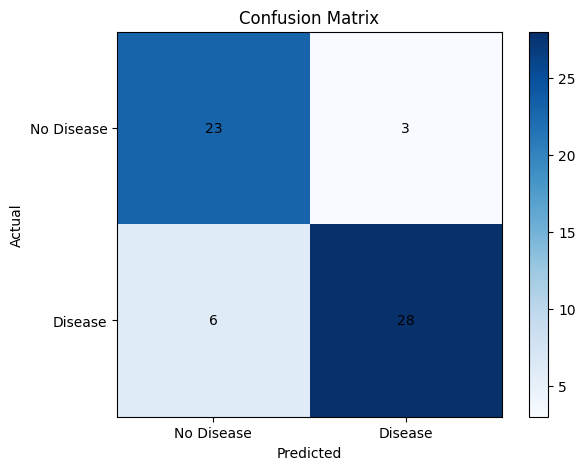

In [47]:
#Plot of Confusion Matrix
fig,ax=plt.subplots()
im=ax.imshow(cm_heart,cmap='Blues',interpolation='nearest')
ax.title.set_text('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Show all ticks and label them
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['No Disease', 'Disease'])
ax.set_yticklabels(['No Disease', 'Disease'])
# Loop over data dimensions and create text annotations.
for i in range(cm_heart.shape[0]):
    for j in range(cm_heart.shape[1]):
        ax.text(j, i, cm_heart[i, j],
                ha="center", va="center", color="black")
plt.colorbar(im)
plt.show()


### 11.5.4 Accuracy, precision, recall, F1

Now we compute the standard classification metrics.

For interpretation:
- **Accuracy**: overall correctness
- **Precision**: among predicted positive, how many are truly positive
- **Recall**: among actual positive, how many we caught
- **F1**: harmonic mean of precision and recall

In [48]:
#Accuracy, precision, recall, F1
acc=accuracy_score(y_test_heart,y_pred_heart)
prec=precision_score(y_test_heart,y_pred_heart)
rec=recall_score(y_test_heart,y_pred_heart)
f1=f1_score(y_test_heart,y_pred_heart)
print('Accuracy:', round(acc, 3))
print('Precision:', round(prec, 3))
print('Recall:', round(rec, 3))
print('F1:', round(f1,3))

Accuracy: 0.85
Precision: 0.903
Recall: 0.824
F1: 0.862


- Is this model missing many disease cases? (look at recall)
- Is it falsely alarming many healthy patients? (look at precision)
- Does F1 look balanced?

**Recall** = 0.824
This means the model correctly finds about 82.4% of actual disease cases.
So, it is missing some disease cases (about 17.6%), but not “many.” It’s reasonably good, but not perfect.

**Precision** = 0.903
This means about 90.3% of the predicted disease cases are actually sick.
So, it is not falsely alarming many healthy patients. False positives are low.

**F1-score** = 0.862
Yes, the F1 score looks well balanced because it sits between precision and recall and is fairly high, showing a good trade-off between the two.

---
# Module 11.6 – ROC Curve and AUC

In this final section we:
- Get predicted probabilities for the positive class
- Compute the ROC curve (TPR vs FPR at different thresholds)
- Compute AUC (Area Under the Curve)
- Interpret what these mean for model quality.

### 11.6.1 Predicted probabilities

For ROC curves, we do not use just the final predictions (0 or 1).
We use the **predicted probability** of the positive class.

In [49]:
#Predicted probabilities

y_prob_heart=tree_heart.predict_proba(X_test_heart)[:,1]
y_prob_heart

array([0.875     , 0.        , 0.04761905, 0.        , 0.875     ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 0.04761905, 0.125     , 0.        , 0.        ,
       0.        , 0.875     , 1.        , 0.875     , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       0.04761905, 1.        , 0.        , 0.875     , 0.08333333,
       0.08333333, 0.04761905, 1.        , 0.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 0.        ,
       0.875     , 0.        , 0.        , 0.        , 0.        ,
       0.8       , 1.        , 1.        , 1.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.04761905, 0.08333333, 0.04761905, 1.        , 0.        ])

### 11.6.2 ROC curve and AUC

We now compute:
- `fpr` (false positive rate)
- `tpr` (true positive rate)
- `thresholds` used

Then we compute **AUC** and plot the ROC curve.

In [50]:
#ROC curve and AUC
fpr,tpr,threshold=roc_curve(y_test_heart,y_prob_heart)
roc_auc=auc(fpr,tpr)
print('AUC:', round(roc_auc, 3))

AUC: 0.925


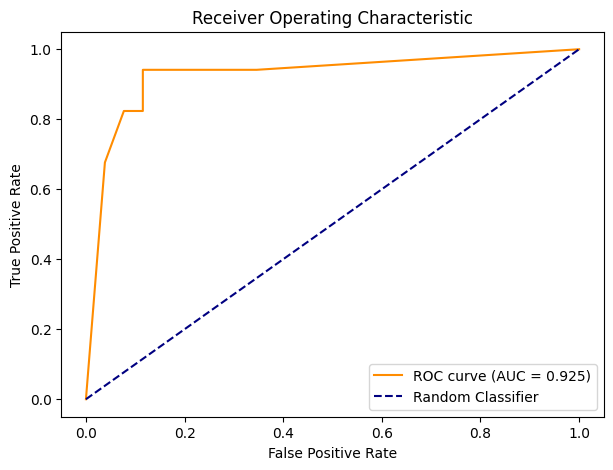

In [51]:
#Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label=f'ROC curve (AUC ={roc_auc: .3f})' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Interpretation tips:
- A curve closer to the **top-left corner** is better.
- AUC near 1.0 means strong separation between classes.
- AUC near 0.5 means the model is no better than random.

---
# Wrap-up

In this single notebook you have seen:
- How to build and visualize a simple decision tree (11.3)
- How deep trees can overfit and how pruning helps (11.4)
- How to evaluate a classifier using confusion matrix and metrics (11.5)
- How to use ROC curve and AUC for threshold-independent evaluation (11.6)

Your task would be to replace the synthetic data with real datasets like heart disease, Titanic, or your own custom data.